[View in Colaboratory](https://colab.research.google.com/github/big-data-bolivia-community/kaggle-nyc-taxi-trip-duration/blob/master/nyc_taxi_trip_duration_using_decision_tree_method.ipynb)

In [0]:
#Primero hay que llamar a unas librerías que el programa necesitará.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

#Autentificacion
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Para graficar el arbol de desicion
!apt-get -qq install -y graphviz && pip install -U -q graphviz
import graphviz

In [0]:
#authenticate
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [13]:
# Descargar el archivo train.csv sobre el entorno
train_download = drive.CreateFile({'id':'1UzauSLR8olyrcPnuMS2cFrighHuEiKqR'})
train_download.GetContentFile('data.csv')
df_data = pd.read_csv('data.csv')

#Eliminamos los datos con valores missing porque Python no puede hacer árboles con datos missing
print('Filas y Columnas antes de la eliminacion de datos erroneos:  ', df_data.shape)
dataset = df_data.dropna()
print('Filas y Columnas despues de la eliminacion de datos erroneos:', dataset.shape)
print('Tipo de objeto de la variable dataset: ', type(dataset))

Filas y Columnas antes de la eliminacion de datos erroneos:   (1458644, 11)
Filas y Columnas despues de la eliminacion de datos erroneos: (1458644, 11)
Tipo de dato de la variable dataset:  <class 'pandas.core.frame.DataFrame'>


In [0]:
def haversine(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    
    return km

In [15]:
dataset.pickup_datetime = pd.to_datetime(dataset.pickup_datetime)
dataset.dropoff_datetime = pd.to_datetime(dataset.dropoff_datetime)

dataset['pickup_hour'] = dataset.pickup_datetime.dt.hour
dataset['pickup_minute'] = dataset.pickup_datetime.dt.minute
dataset['pickup_year'] = dataset.pickup_datetime.dt.year
dataset['pickup_day'] = dataset.pickup_datetime.dt.day
dataset['pickup_month'] = dataset.pickup_datetime.dt.month
dataset['pickup_day_year'] = dataset.pickup_datetime.dt.dayofyear
dataset['pickup_day_week'] = dataset.pickup_datetime.dt.dayofweek

dataset['dropoff_hour'] = dataset.dropoff_datetime.dt.hour
dataset['dropoff_minute'] = dataset.dropoff_datetime.dt.minute
dataset['dropoff_year'] = dataset.dropoff_datetime.dt.year
dataset['dropoff_day'] = dataset.dropoff_datetime.dt.day
dataset['dropoff_month'] = dataset.dropoff_datetime.dt.month
dataset['dropoff_day_year'] = dataset.dropoff_datetime.dt.dayofyear
dataset['dropoff_day_week'] = dataset.dropoff_datetime.dt.dayofweek

dataset['distance'] = haversine(dataset.pickup_longitude, dataset.pickup_latitude, 
                                dataset.dropoff_longitude, dataset.dropoff_latitude)

dataset.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
pickup_hour                    int64
pickup_minute                  int64
pickup_year                    int64
pickup_day                     int64
pickup_month                   int64
pickup_day_year                int64
pickup_day_week                int64
dropoff_hour                   int64
dropoff_minute                 int64
dropoff_year                   int64
dropoff_day                    int64
dropoff_month                  int64
dropoff_day_year               int64
dropoff_day_week               int64
distance                     float64
dtype: object

In [0]:
dataset.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_hour,pickup_minute,pickup_year,...,pickup_day_year,pickup_day_week,dropoff_hour,dropoff_minute,dropoff_year,dropoff_day,dropoff_month,dropoff_day_year,dropoff_day_week,distance
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1458644.0,...,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1458644.0,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02,1.360648e+01,2.959016e+01,2016.0,...,9.183607e+01,3.050375e+00,1.359890e+01,2.962843e+01,2016.0,1.550448e+01,3.517178e+00,9.184747e+01,3.054422e+00,3.438704e+00
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03,6.399693e+00,1.732471e+01,0.0,...,5.156608e+01,1.954039e+00,6.483682e+00,1.742023e+01,0.0,8.703123e+00,1.681217e+00,5.156697e+01,1.956599e+00,4.293840e+00
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00,0.000000e+00,0.000000e+00,2016.0,...,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2016.0,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02,9.000000e+00,1.500000e+01,2016.0,...,4.800000e+01,1.000000e+00,9.000000e+00,1.500000e+01,2016.0,8.000000e+00,2.000000e+00,4.800000e+01,1.000000e+00,1.231063e+00
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02,1.400000e+01,3.000000e+01,2016.0,...,9.200000e+01,3.000000e+00,1.400000e+01,3.000000e+01,2016.0,1.500000e+01,4.000000e+00,9.200000e+01,3.000000e+00,2.092403e+00
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03,1.900000e+01,4.500000e+01,2016.0,...,1.360000e+02,5.000000e+00,1.900000e+01,4.500000e+01,2016.0,2.300000e+01,5.000000e+00,1.360000e+02,5.000000e+00,3.872904e+00
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06,2.300000e+01,5.900000e+01,2016.0,...,1.820000e+02,6.000000e+00,2.300000e+01,5.900000e+01,2016.0,3.100000e+01,7.000000e+00,1.830000e+02,6.000000e+00,1.240130e+03


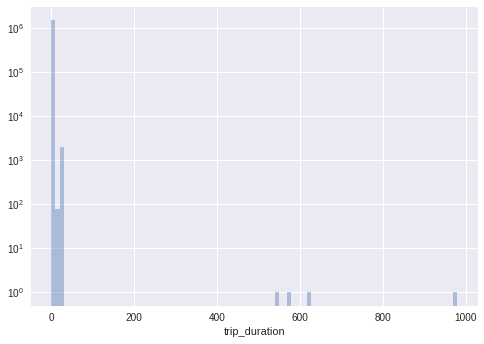

In [0]:
fig, ax = plt.subplots(ncols=1, nrows=1)
sns.distplot(dataset['trip_duration']/3600, ax=ax, bins=100, kde=False, hist_kws={'log':True})

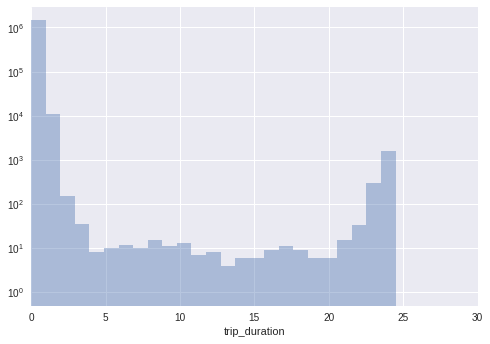

In [0]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.set_xlim(0,30)
sns.distplot(dataset['trip_duration']/3600, ax=ax, bins=1000, kde=False, hist_kws={'log':True})

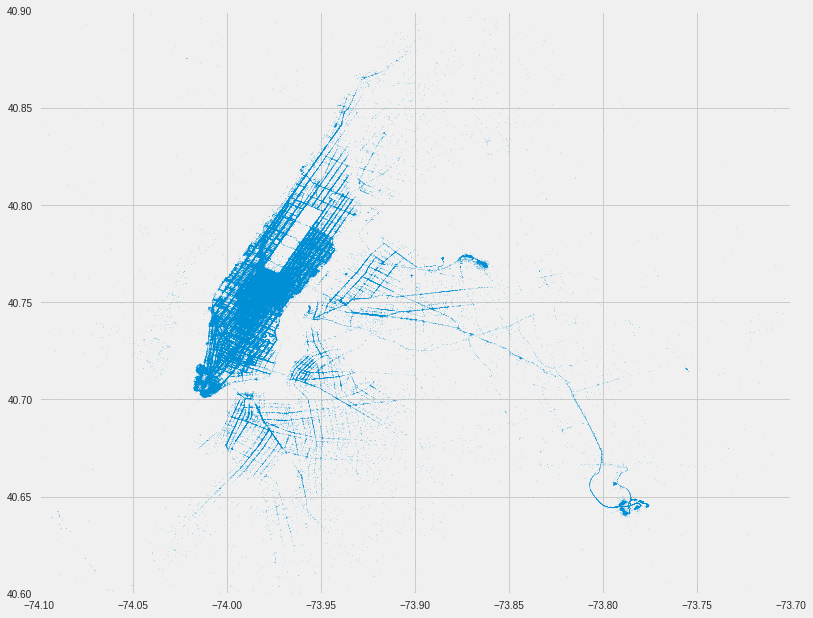

In [0]:
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
plt.ylim(40.6, 40.9)
plt.xlim(-74.1,-73.7)
ax.scatter(dataset['pickup_longitude'], dataset['pickup_latitude'], s=0.01, alpha=1)

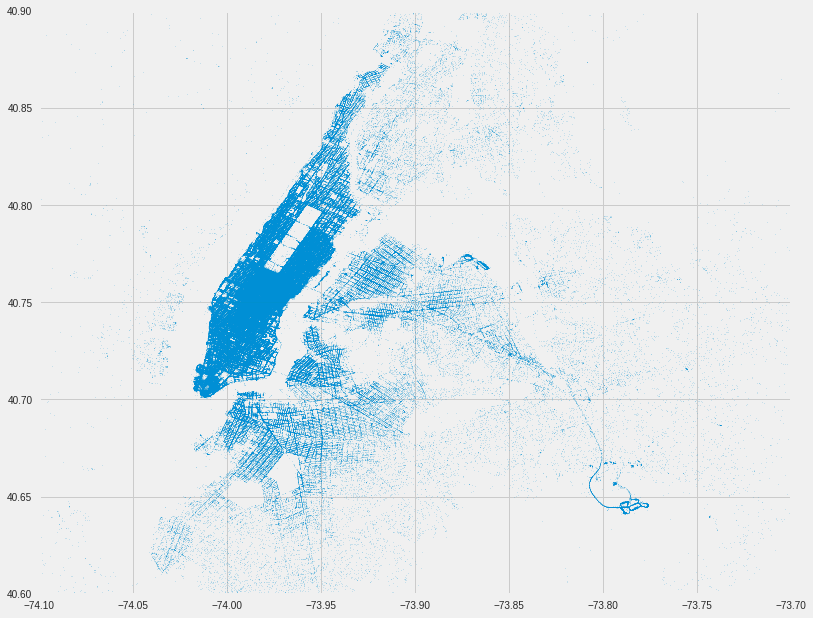

In [0]:
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
plt.ylim(40.6, 40.9)
plt.xlim(-74.1,-73.7)
ax.scatter(dataset['dropoff_longitude'], dataset['dropoff_latitude'], s=0.01, alpha=1)

In [16]:
#Indicamos las variables predictoras y debajo la variable objetivo y deberan ser datos numericos
predictors = dataset[['passenger_count', 'distance',
                         'pickup_hour',  'pickup_minute',  'pickup_day_year', 'pickup_day_week',  'pickup_month',  'pickup_longitude',  'pickup_latitude', 
                         'dropoff_hour', 'dropoff_minute', 'dropoff_day_year','dropoff_day_week', 'dropoff_month', 'dropoff_longitude', 'dropoff_latitude']]

targets = dataset.trip_duration

train_features, test_features, train_targets, test_targets = train_test_split(predictors, targets, test_size=0.3, random_state=0)  

print('test features shape: ', test_features.shape)
print('test targets shape: ', test_targets.shape)

print('train features shape: ', train_features.shape)
print('train targets shape: ', train_targets.shape)

test features shape:  (437594, 16)
test targets shape:  (437594,)
train features shape:  (1021050, 16)
train targets shape:  (1021050,)


Text(0.5,1,'Train Values')

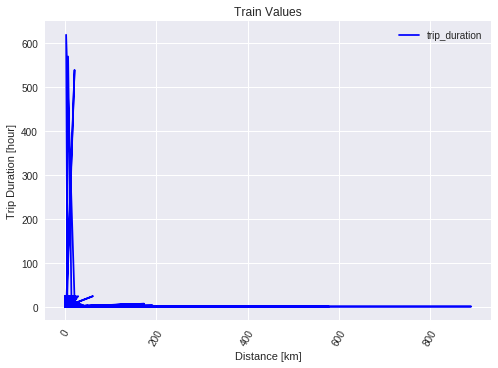

In [17]:
# Plot los valores actuales de entrenamientos
plt.plot(train_features['distance'], train_targets/3600, 'b-')

plt.xticks(rotation = '60'); 
plt.legend()

# Graficar etiquetas
plt.xlabel('Distance [km]')
plt.ylabel('Trip Duration [hour]')
plt.title('Train Values')

In [0]:
#Construimos el árbol con los datos de entrenamiento
#regressor = DecisionTreeRegressor(max_depth=2)  # MAE 7.55 minutes, R2 0.0076
#regressor = DecisionTreeRegressor(max_depth=3)  # MAE 7.26 minutes, R2 0.0054
#regressor = DecisionTreeRegressor(max_depth=5)  # MAE 7.09 minutes, R2 0.0076
#regressor = DecisionTreeRegressor(max_depth=10) # MAE 6.63 minutes, R2 -0.72
regressor = DecisionTreeRegressor(max_depth=15) # MAE 6.08 minutes, R2 -1.20
#regressor = DecisionTreeRegressor(max_depth=20) # MAE 5.88 minutes, R2 -0.60
#regressor = DecisionTreeRegressor(max_depth=25) # MAE 5.78 minutes, R2 -0.67
#regressor = DecisionTreeRegressor(max_depth=30) # MAE 6.89 minutes, R2 -0.69

regressor = regressor.fit(train_features, train_targets)

print('node_count => ', regressor.tree_.node_count)

regressor.get_params()

node_count =>  8447


{'criterion': 'mse',
 'max_depth': 15,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

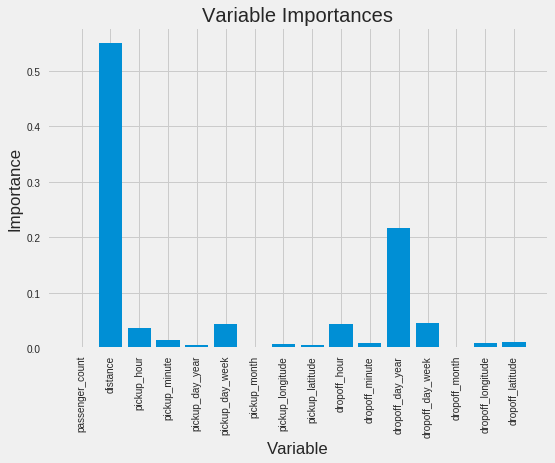

In [0]:
# Saving feature names for later use
feature_list = list(predictors.columns)
importances = list(regressor.feature_importances_)

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [0]:
#Predecimos para los valores del grupo Test
predictions = regressor.predict(test_features)
df = pd.DataFrame({'Actual':test_targets, 'Predicted':predictions})  
df

,Actual,Predicted
571578,113,331.931140
1280332,2037,1348.250000
177838,1811,2053.927083
1433776,977,1016.750000
757662,342,398.476313
737011,881,1139.361702
402752,611,409.502809
179791,806,1086.285714
895734,470,321.200000
821808,1235,1199.250000


In [0]:
print('Mean Absolute Error {} [min]'.format(metrics.mean_absolute_error(test_targets, predictions)/60)) # minutes
print('Mean Absolute Error {} [sec]'.format(metrics.mean_absolute_error(test_targets, predictions)))    # seconds
print('Root Mean Squared Error {} [min]'.format(np.sqrt(metrics.mean_squared_error(test_targets, predictions))/60)) # minutes
print('Root Mean Squared Error {} [sec]'.format(np.sqrt(metrics.mean_squared_error(test_targets, predictions))))    # seconds
print('Mean Squared Error {} [min]'.format(metrics.mean_squared_error(test_targets, predictions)/60)) # minutes
print('Mean Squared Error {} [sec]'.format(metrics.mean_squared_error(test_targets, predictions)))    # seconds
print('R Square: ', metrics.r2_score(test_targets, predictions)) # 1 es lo mejor

Mean Absolute Error 5.789538543211226 [min]
Mean Absolute Error 347.37231259267355 [sec]
Root Mean Squared Error 126.60658578225201 [min]
Root Mean Squared Error 7596.3951469351205 [sec]
Mean Squared Error 961753.6538063242 [min]
Mean Squared Error 57705219.22837945 [sec]
R Square:  -0.5180532780572986


Text(0.5,1,'Actual and Predicted Values')

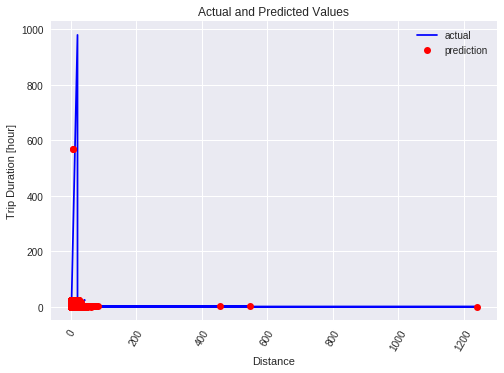

In [0]:
# Plot los valores actuales
plt.plot(test_features['distance'], test_targets/3600, 'b-', label = 'actual')

# Plot los valores de prediccion
plt.plot(test_features['distance'], predictions/3600, 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()

# Graficar etiquetas
plt.xlabel('Distance')
plt.ylabel('Trip Duration [hour]')
plt.title('Actual and Predicted Values')